In [1]:
!pip install pyspark
!pip install scikit-learn

from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("TelcoChurn").getOrCreate()

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import json
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml import Pipeline, Model
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType,BooleanType,DateType

df = pd.read_csv("Telco-Customer-Churn.csv")

In [3]:
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [4]:
df = df.drop('customerID',axis=1)
df.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [6]:
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7043,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6531,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


If the above df.info shows the "TotalCharges" columnn as an object, we'll need to convert it to numeric. If you have already done this during a previous exercise for "Data Visualization with Data Refinery", you can skip to step 2.4.

In [7]:
totalCharges = df.columns.get_loc("TotalCharges")
new_col = pd.to_numeric(df.iloc[:, totalCharges], errors='coerce')
df.iloc[:, totalCharges] = pd.Series(new_col)

In [8]:
df.describe(include = 'all')

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
count,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043.000000,7032.0,7043
unique,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4,NaN,6530.0,2
top,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,NaN,20.2,No
freq,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365,NaN,11.0,5174
mean,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN,NaN
std,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN,NaN
min,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN,NaN
25%,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN,NaN
50%,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN,NaN
75%,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN,NaN


In [9]:
print(df.isnull().values.any())
df.isnull().sum()

True


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


We should see that the TotalCharges column has missing values. There are various ways we can address this issue:

*   Drop records with missing values
*   Fill in the missing value with one of the following strategies: Zero, Mean of the values for the column, Random value, etc).

In [10]:


# Find the column number for TotalCharges (starting at 0).
total_charges_idx = df.columns.get_loc("TotalCharges")
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

df.iloc[:, total_charges_idx] = imputer.fit_transform(df.iloc[:, total_charges_idx].values.reshape(-1, 1))
df.iloc[:, total_charges_idx] = pd.Series(df.iloc[:, total_charges_idx])

In [11]:
# Validate that we have addressed any NaN values
print(df.isnull().values.any())
df.isnull().sum()

False


,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0
OnlineBackup,0


## Categorize Features
We will categorize some of the columns / features based on wether they are categorical values or continuous (i.e numerical) values. We will use this in later sections to build visualizations.

In [12]:
columns_idx = np.s_[0:] # Slice of first row(header) with all columns.
first_record_idx = np.s_[0] # Index of first record

string_fields = [type(fld) is str for fld in df.iloc[first_record_idx, columns_idx]] # All string fields
all_features = [x for x in df.columns if x != 'Churn']
categorical_columns = list(np.array(df.columns)[columns_idx][string_fields])
categorical_features = [x for x in categorical_columns if x != 'Churn']
continuous_features = [x for x in all_features if x not in categorical_features]

print('All Features: ', all_features)
print('\nCategorical Features: ', categorical_features)
print('\nContinuous Features: ', continuous_features)
print('\nAll Categorical Columns: ', categorical_columns)

All Features:  ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

Categorical Features:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Continuous Features:  ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

All Categorical Columns:  ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


## Visualize data
Data visualization can be used to find patterns, detect outliers, understand distribution and more. We can use graphs such as:


*   Histograms, boxplots, etc: To find distribution of our continuous variables.
*   Bar charts: To show frequency in categorical values.

In [13]:
%matplotlib inline
sns.set(style="darkgrid")
sns.set_palette("hls", 3)

Churn
No     5174
Yes    1869
dtype: int64


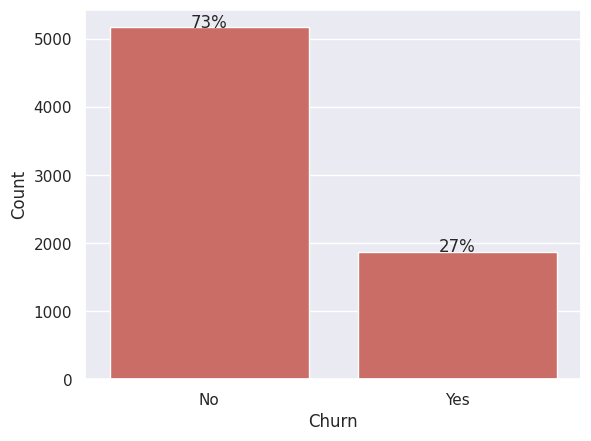

In [14]:
#First, we get a high level view of the distribution of Churn. What percentage of customer in our dataset are churning vs not churning.
print(df.groupby(['Churn']).size())
churn_plot = sns.countplot(data=df, x='Churn', order=df.Churn.value_counts().index)
plt.ylabel('Count')
for p in churn_plot.patches:
    height = p.get_height()
    churn_plot.text(p.get_x()+p.get_width()/2., height + 1,'{0:.0%}'.format(height/float(len(df))),ha="center")
plt.show()

We can get use frequency counts charts to get an understanding of the categorical features relative to Churn


* We can see that for the gender feature. We have relatively equal rates of churn by gender.
* We can see that for the InternetService feature. We have higher churn for those that have "Fiber optic" service versus those with "DSL"

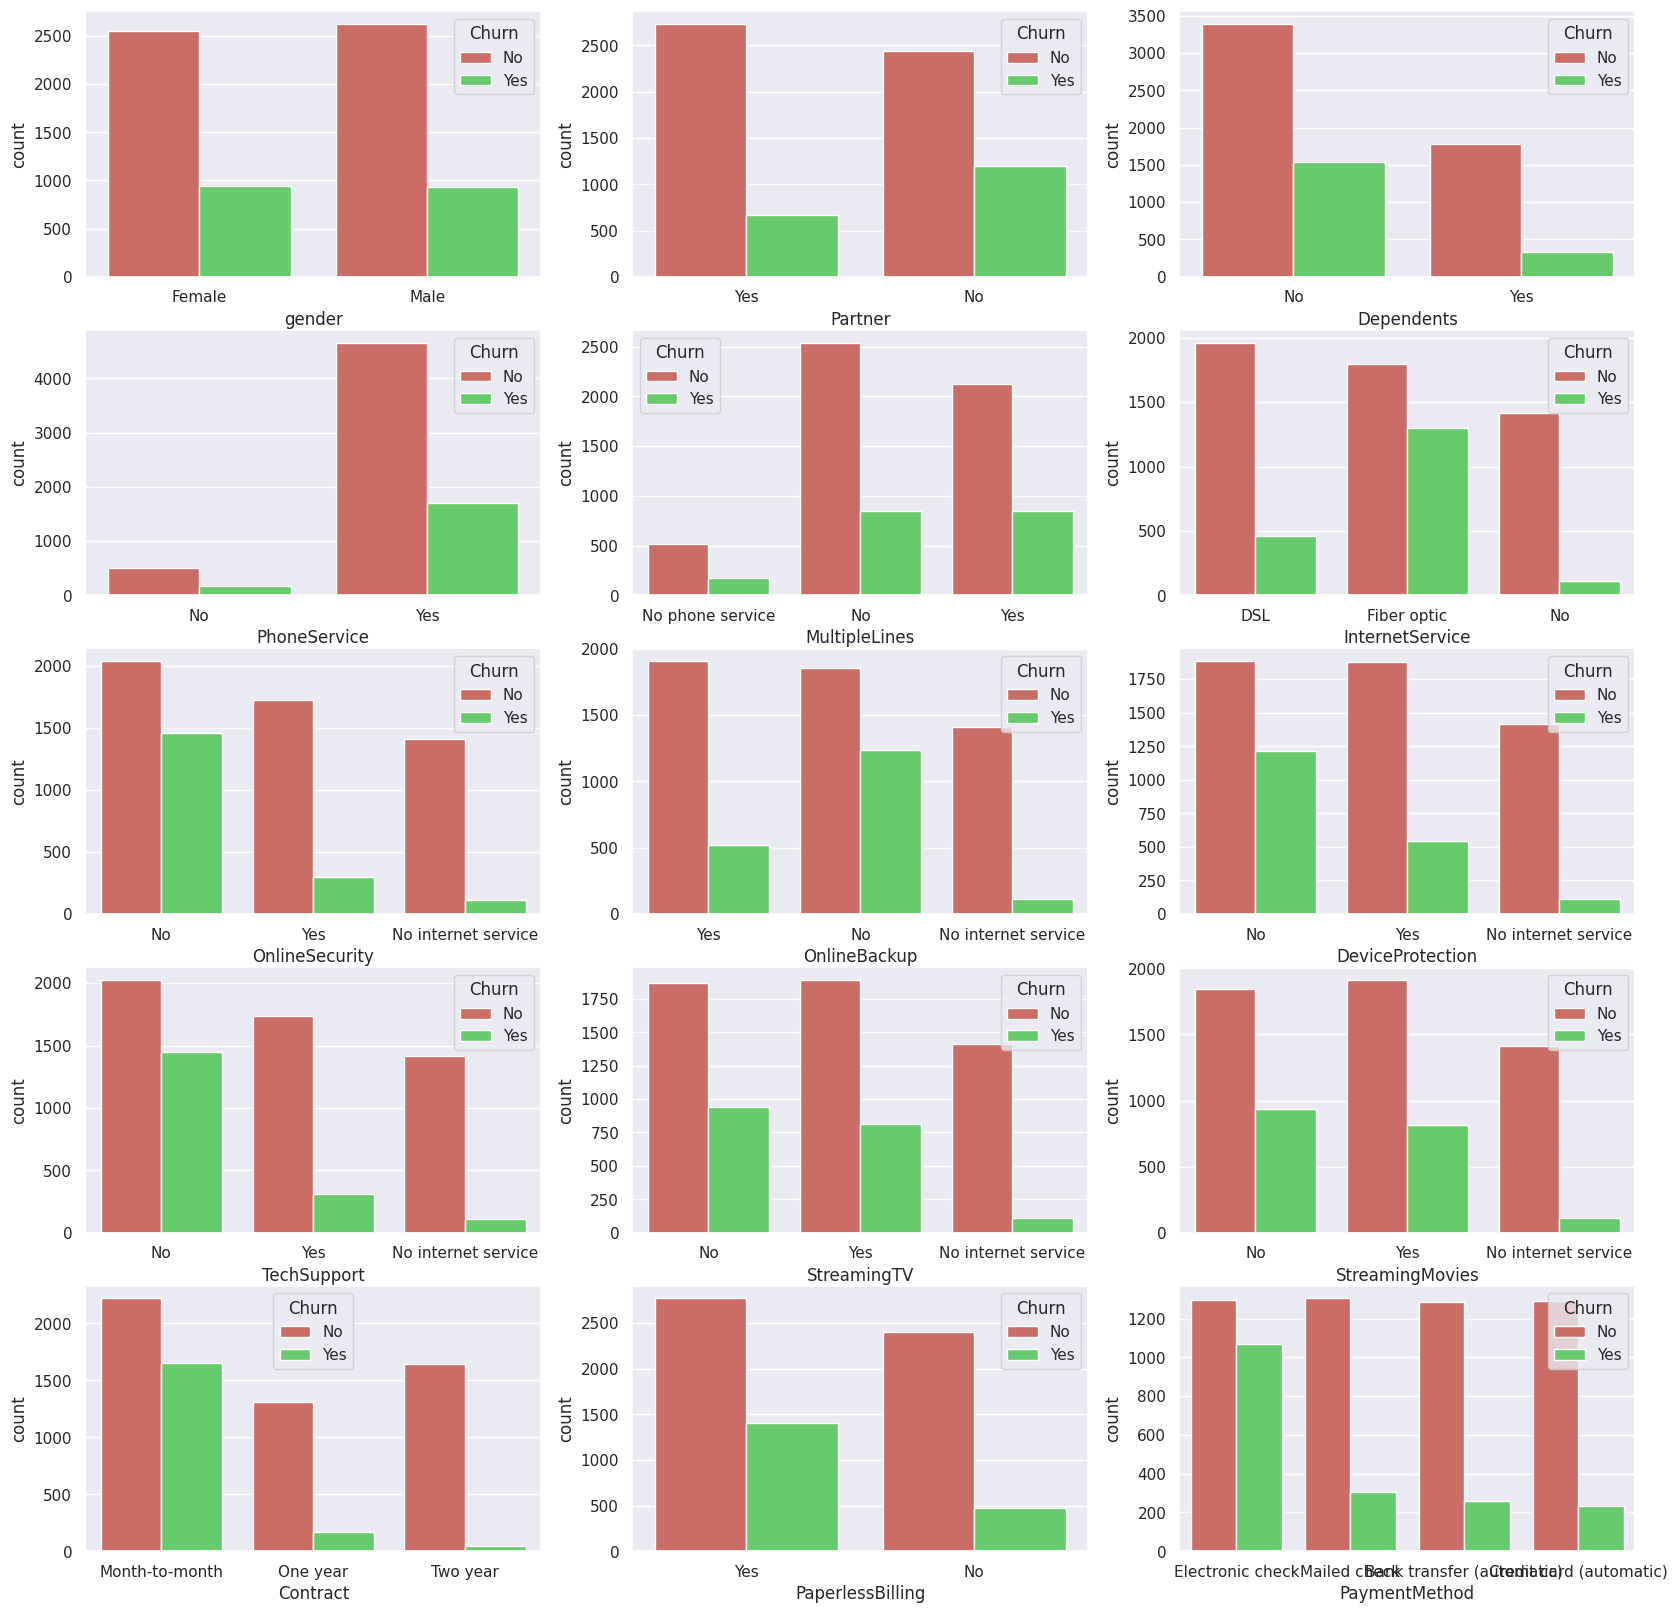

In [15]:
# Categorical feature count plots
f, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12), (ax13, ax14, ax15)) = plt.subplots(5, 3, figsize=(20, 20))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15 ]

for i in range(len(categorical_features)):
    sns.countplot(x = categorical_features[i], hue="Churn", data=df, ax=ax[i])

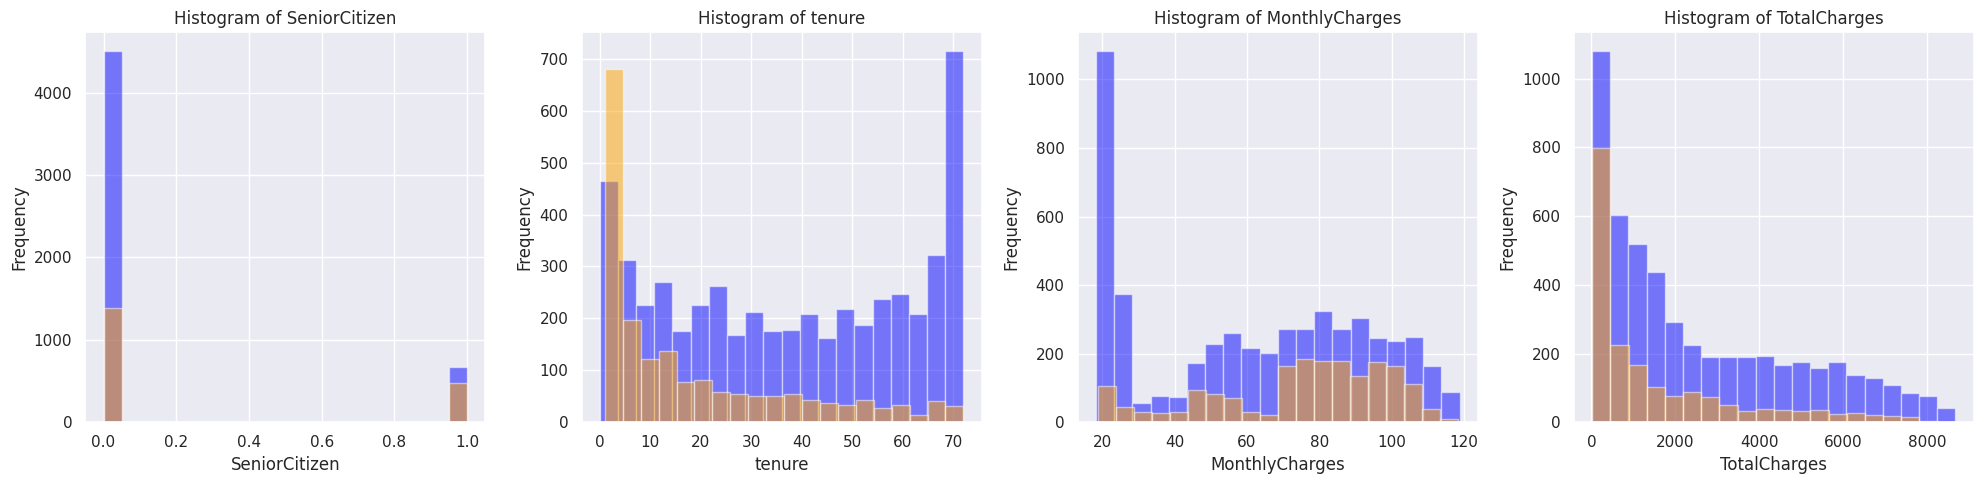

In [16]:
# Determine the number of continuous features
num_continuous_features = len(continuous_features)

# Create a subplot grid that matches the number of continuous features
# For three features, use a 1x3 grid
fig, ax = plt.subplots(1, num_continuous_features, figsize=(20, 5))

# Flatten the ax array if it's 2D
if num_continuous_features == 1:
    ax = [ax]
else:
    ax = ax.flatten()

# Plot histograms for each continuous feature
for i, feature in enumerate(continuous_features):
    df[df.Churn == 'No'][feature].hist(bins=20, color="blue", alpha=0.5, ax=ax[i])
    df[df.Churn == 'Yes'][feature].hist(bins=20, color="orange", alpha=0.5, ax=ax[i])

# Add titles and labels for clarity
for i, feature in enumerate(continuous_features):
    ax[i].set_title(f'Histogram of {feature}')
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


Now we can create our machine learning model. You could use the insights / intuition gained from the data visualization steps above to what kind of model to create or which features to use. We will create a simple classification model.

In [17]:
spark = SparkSession.builder.getOrCreate()
df_data = spark.createDataFrame(df)
df_data.head()

Row(gender='Female', SeniorCitizen=0, Partner='Yes', Dependents='No', tenure=1, PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=29.85, TotalCharges=29.85, Churn='No')

In [18]:
spark_df = df_data
(train_data, test_data) = spark_df.randomSplit([0.8, 0.2], 24)

print("Number of records for training: " + str(train_data.count()))
print("Number of records for evaluation: " + str(test_data.count()))

Number of records for training: 5644
Number of records for evaluation: 1399


In [19]:
spark_df.printSchema()

root
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: long (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: long (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [20]:
si_gender = StringIndexer(inputCol = 'gender', outputCol = 'gender_IX')
si_Partner = StringIndexer(inputCol = 'Partner', outputCol = 'Partner_IX')
si_Dependents = StringIndexer(inputCol = 'Dependents', outputCol = 'Dependents_IX')
si_PhoneService = StringIndexer(inputCol = 'PhoneService', outputCol = 'PhoneService_IX')
si_MultipleLines = StringIndexer(inputCol = 'MultipleLines', outputCol = 'MultipleLines_IX')
si_InternetService = StringIndexer(inputCol = 'InternetService', outputCol = 'InternetService_IX')
si_OnlineSecurity = StringIndexer(inputCol = 'OnlineSecurity', outputCol = 'OnlineSecurity_IX')
si_OnlineBackup = StringIndexer(inputCol = 'OnlineBackup', outputCol = 'OnlineBackup_IX')
si_DeviceProtection = StringIndexer(inputCol = 'DeviceProtection', outputCol = 'DeviceProtection_IX')
si_TechSupport = StringIndexer(inputCol = 'TechSupport', outputCol = 'TechSupport_IX')
si_StreamingTV = StringIndexer(inputCol = 'StreamingTV', outputCol = 'StreamingTV_IX')
si_StreamingMovies = StringIndexer(inputCol = 'StreamingMovies', outputCol = 'StreamingMovies_IX')
si_Contract = StringIndexer(inputCol = 'Contract', outputCol = 'Contract_IX')
si_PaperlessBilling = StringIndexer(inputCol = 'PaperlessBilling', outputCol = 'PaperlessBilling_IX')
si_PaymentMethod = StringIndexer(inputCol = 'PaymentMethod', outputCol = 'PaymentMethod_IX')

In [21]:
si_Label = StringIndexer(inputCol="Churn", outputCol="label").fit(spark_df)
label_converter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=si_Label.labels)

In [22]:
va_features = VectorAssembler(inputCols=['gender_IX',  'SeniorCitizen', 'Partner_IX', 'Dependents_IX', 'PhoneService_IX', 'MultipleLines_IX', 'InternetService_IX', \
                                         'OnlineSecurity_IX', 'OnlineBackup_IX', 'DeviceProtection_IX', 'TechSupport_IX', 'StreamingTV_IX', 'StreamingMovies_IX', \
                                         'Contract_IX', 'PaperlessBilling_IX', 'PaymentMethod_IX', 'TotalCharges', 'MonthlyCharges'], outputCol="features")

Assemble all the stages into a pipeline. We don't expect a clean linear regression, so we'll use RandomForestClassifier to find the best decision tree for the data.

In [23]:
classifier = RandomForestClassifier(featuresCol="features")

pipeline = Pipeline(stages=[si_gender, si_Partner, si_Dependents, si_PhoneService, si_MultipleLines, si_InternetService, si_OnlineSecurity, si_OnlineBackup, si_DeviceProtection, \
                            si_TechSupport, si_StreamingTV, si_StreamingMovies, si_Contract, si_PaperlessBilling, si_PaymentMethod, si_Label, va_features, \
                            classifier, label_converter])

model = pipeline.fit(train_data)

In [24]:
predictions = model.transform(test_data)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction")
area_under_curve = evaluatorDT.evaluate(predictions)

evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderROC')
area_under_curve = evaluatorDT.evaluate(predictions)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol="prediction",  metricName='areaUnderPR')
area_under_PR = evaluatorDT.evaluate(predictions)
print("areaUnderROC = %g" % area_under_curve)

areaUnderROC = 0.66913


In [25]:
model.save("telco_churn_model")

In [26]:
write_score_CSV = test_data.toPandas().drop(['Churn'], axis=1)
write_score_CSV.to_csv("TelcoCustomerSparkMLBatchScore.csv", index=False)

write_eval_CSV = test_data.toPandas()
write_eval_CSV.to_csv("TelcoCustomerSparkMLEval.csv", index=False)